In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import sklearn.metrics as metrics
import torch
from ray import air, tune
from ray.air import session

import flippers
from flippers.models import SnorkelModel

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.utils import load_wrench_dataset, MetricsUtil

In [6]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
Best_Configs = {}
Results = {}
Metrics = {}

In [7]:
dataset_to_metric = {
    "imdb": "Accuracy",
    "yelp": "Accuracy",
    "youtube": "Accuracy",
    "sms": "F1",
    "agnews": "Accuracy",
    "trec": "Accuracy",
    "spouse": "F1",
    "cdr": "F1",
    "semeval": "Accuracy",
    "chemprot": "Accuracy",
    "commercial": "F1",
    "tennis": "F1",
    "basketball": "F1",
    "census": "F1",
}

In [8]:
%%time

# Define a search space and initialize the search algorithm.
search_space = {
    "learning_rate": tune.grid_search([1e-2, 5e-3, 1e-3]),
    "num_epochs": tune.grid_search([10, 50, 100, 200]),
    "k": tune.grid_search([0, 1e-1, 5e-2, 1e-2, 5e-3, 1e-4]),
}

for dataset in datasets:
    data, weak_labels, polarities = load_wrench_dataset(dataset)
    train, dev, test = data
    L_train, L_dev, L_test = weak_labels
    del train

    y_dev = dev["label"].values.astype(int)
    y_test = test["label"].values.astype(int)

    class_balances = list(
        dev["label"].astype(int).value_counts(normalize=True).sort_index()
    )

    # Wrap SnorkelModel in an objective function
    def objective(config):
        m = SnorkelModel(polarities=polarities, class_balances=class_balances)
        m.fit(L_train, **config)
        scores = MetricsUtil(L=L_dev, y_true=y_dev).score(m, plots=False)  # Compute validation metrics
        session.report(scores)  # Report to Tune

    # Start a Tune run that maximizes metric on dev set
    tuner = tune.Tuner(
        tune.with_resources(objective, {"cpu": 8, "gpu": 0.5}),
        param_space=search_space,
        run_config=air.RunConfig(progress_reporter=tune.JupyterNotebookReporter()),
    )
    results = tuner.fit()

    metric = dataset_to_metric[dataset]
    best_result = results.get_best_result(metric=metric, mode="max")
    Best_Configs[dataset] = best_result.config
    Results[dataset] = results

    m = SnorkelModel(polarities=polarities, class_balances=class_balances)
    config = best_result.config
    m.fit(L_train, **config)

    Metrics[dataset] = MetricsUtil(L=L_test, y_true=y_test).score(m, plots=False)

Trial name,AUC,Accuracy,Average_Precision,Balanced_Accuracy,F1,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_c7521_00000,0.893,0.891,0.863,0.883,0.864,2023-05-07_21-57-14,True,,71350f1f48ee4867a2aed346e8a4cb25,"0_k=0,learning_rate=0.0100,num_epochs=10",LAPTOP,1,127.0.0.1,31092,0.569685,0.569685,0.569685,1683521834,0,,1,c7521_00000,0.015028
objective_c7521_00002,0.893,0.891,0.863,0.883,0.864,2023-05-07_21-57-21,True,,71350f1f48ee4867a2aed346e8a4cb25,"2_k=0.0500,learning_rate=0.0100,num_epochs=10",LAPTOP,1,127.0.0.1,31092,0.142195,0.142195,0.142195,1683521841,0,,1,c7521_00002,0.015028


2023-05-07 21:57:39,075	INFO tune.py:798 -- Total run time: 33.57 seconds (33.46 seconds for the tuning loop).


CPU times: total: 28.9 s
Wall time: 5min 32s


In [12]:
df = pd.DataFrame(Metrics)


# Formatting function to underline entries
def underline_entries(x):
    is_metric = x.index == dataset_to_metric[x.name]
    return ["text-decoration: underline" if v else "" for v in is_metric]


# Underlines the metrics used in the wrench benchmark
df.style.apply(underline_entries).format("{:.3f}")

,cdr,yelp,youtube,census,spouse,basketball,sms,tennis
F1,0.712,0.763,0.823,0.608,0.503,0.174,0.071,0.824
Average_Precision,0.669,0.803,0.900,0.652,0.387,0.117,0.144,0.798
AUC,0.862,0.781,0.861,0.841,0.801,0.527,0.505,0.887
Accuracy,0.782,0.738,0.852,0.808,0.911,0.549,0.844,0.874
Balanced_Accuracy,0.796,0.735,0.845,0.746,0.751,0.515,0.506,0.874


In [10]:
pd.DataFrame(Best_Configs)

,cdr,yelp,youtube,census,spouse,basketball,sms,tennis
learning_rate,0.005,0.010,0.001,0.005,0.01,0.01,0.01,0.01
num_epochs,10.000,10.000,10.000,50.000,10.00,10.00,10.00,10.00
k,0.000,0.005,0.050,0.050,0.00,0.10,0.00,0.00


# Inspect best hyperparameter value per model

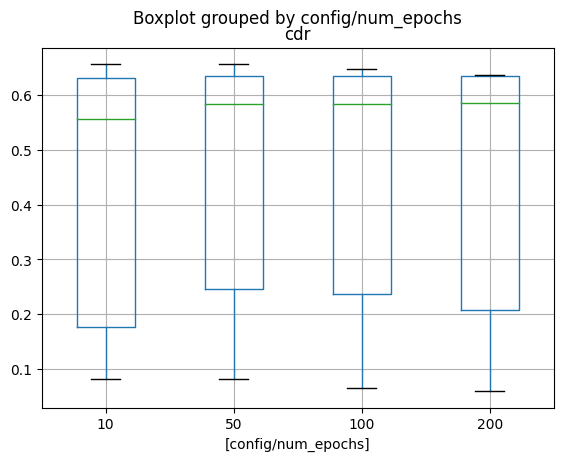

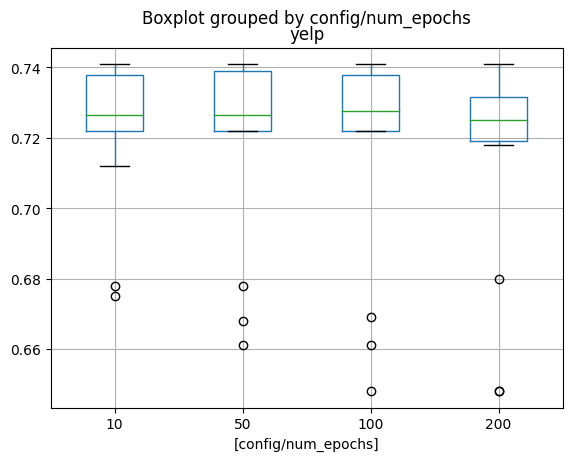

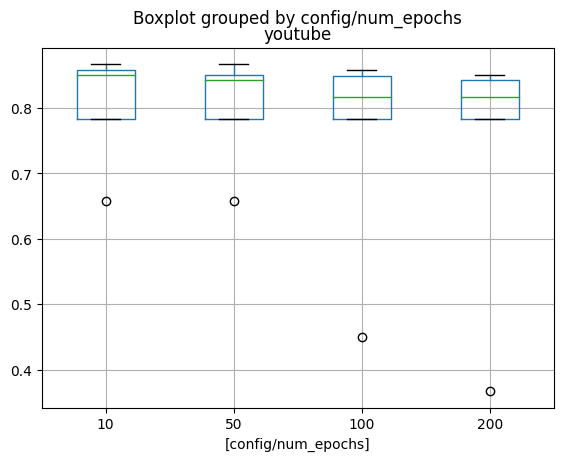

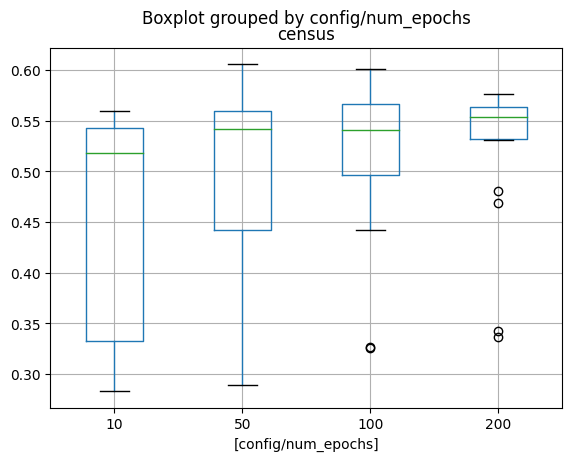

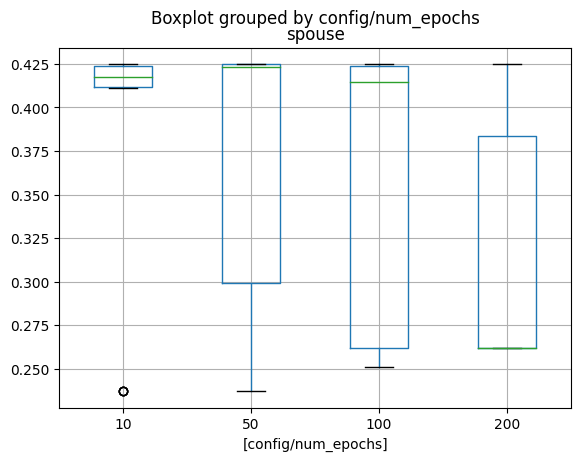

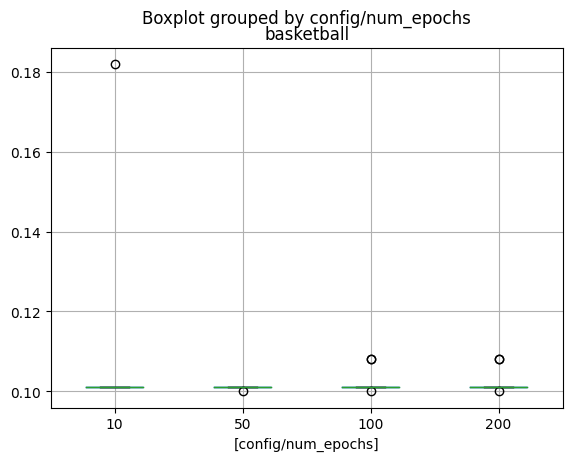

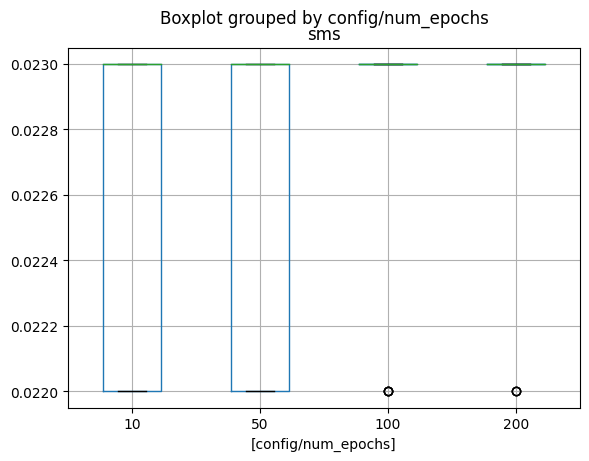

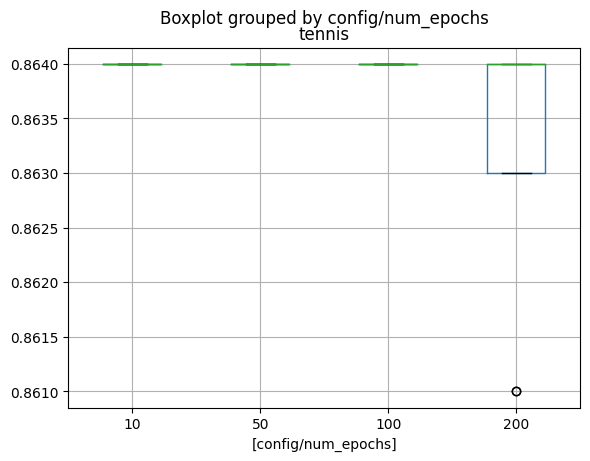

In [11]:
for dataset in datasets:
    grid = Results[dataset]
    hparam = "num_epochs"
    hparam = "config/" + hparam
    grid.get_dataframe()[[dataset_to_metric[dataset], hparam]].boxplot(by=hparam)
    plt.title(dataset)